In [10]:
%load_ext autoreload
%autoreload 2

from models import Detr
from utils import load_config
import torch

config = load_config(r"configs\train.yaml")

model = Detr(
    train_mode = False,
    with_gcn = False,
    pretrained='facebook/detr-resnet-50',
    checkpoint = r"checkpoints\detr-epoch=01-validation\DETRR50_AGB8_loss=0.67.ckpt",
    config=config)

device = torch.device('cuda:0')
model.to(device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DetrForObjectDetection were not initialized from the model checkpoin

Detr(
  (model): DetrForObjectDetection(
    (model): DetrModel(
      (backbone): DetrConvModel(
        (conv_encoder): DetrConvEncoder(
          (model): FeatureListNet(
            (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
            (bn1): DetrFrozenBatchNorm2d()
            (act1): ReLU(inplace=True)
            (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
            (layer1): Sequential(
              (0): Bottleneck(
                (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (bn1): DetrFrozenBatchNorm2d()
                (act1): ReLU(inplace=True)
                (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                (bn2): DetrFrozenBatchNorm2d()
                (drop_block): Identity()
                (act2): ReLU(inplace=True)
                (aa): Identity()
                (conv3): Conv2d(64, 256

torch.Size([1, 100, 256]) torch.Size([1, 100, 4])


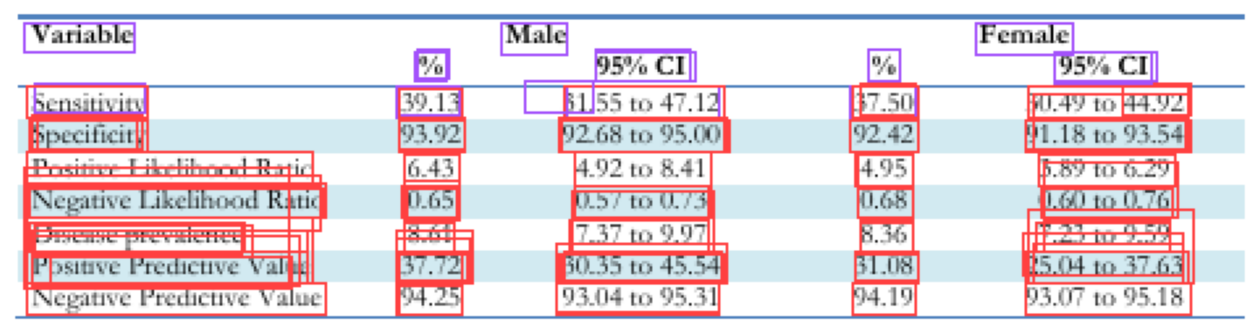

In [9]:
import cv2
import supervision as sv

with torch.no_grad():
    # load image and predict
    image = cv2.imread(r"misc\PMC5402779_004_00.png")
    inputs = model.image_processor(images=image, return_tensors='pt').to(device)
    outputs = model(**inputs)

    print(outputs.last_hidden_state.shape, outputs.pred_boxes.shape)

    # post-process
    target_sizes = torch.tensor([image.shape[:2]]).to(device)
    results = model.image_processor.post_process_object_detection(
        outputs=outputs,
        threshold=0,
        target_sizes=target_sizes
    )[0]

# annotate
detections = sv.Detections.from_transformers(transformers_results=results)

box_annotator = sv.BoxAnnotator(thickness=1)
frame = box_annotator.annotate(scene=image, detections=detections)

%matplotlib inline
sv.plot_image(frame, (16, 16))